In [31]:
import os
import warnings
import joblib
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import tensorflow as tf
import keras.backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import InputLayer
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Add
from keras.layers import Concatenate
from keras.layers import ZeroPadding1D
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPool1D
from keras.layers import AveragePooling1D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import SimpleRNN
from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import text
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from gensim.models.word2vec import Word2Vec

In [16]:
df = joblib.load("../data/df_final_v3.gzip")
df["date"] = pd.to_datetime(df["date"])
df = df[["date", "clean_tweet"]]
df = df.groupby("date")["clean_tweet"].agg(sum)
df.head()

date
2017-01-01    Happy New Year, everyone! Like atUser just tol...
2017-01-03    New Glaeser paper on real estate bubbles sugge...
2017-01-04    China leading financial reformer Peoples Bank ...
2017-01-05    Zhou Xiaochuan: Life for dogs !! - Sign the Pe...
2017-01-06    bis Haruhiko Kuroda: A new phase of the global...
Name: clean_tweet, dtype: object

In [17]:
fx = pd.read_csv("../data/Currency_Data_GBPUSD.csv", index_col=False)
fx.columns = ["currecny", "date", "Open", "High", "Low", "Close"]
fx["date"] = pd.to_datetime(fx["date"])
fx.sort_values(by='date', inplace=True)
fx.reset_index(drop=True, inplace=True)
fx["label"] = fx["Close"].diff(periods=1)
fx.dropna(inplace=True)
fx.drop("currecny", axis=1, inplace=True)
fx["label"] = fx["label"].map(lambda x: 1 if float(x)>=0 else 0)
fx.head()

,date,Open,High,Low,Close,label
1,2007-01-10,2.0434,2.0446,2.0370,2.0418,1
2,2007-01-11,2.0797,2.0874,2.0755,2.0801,1
3,2007-02-08,2.0324,2.0378,2.0282,2.0374,0
4,2007-02-11,2.0801,2.0898,2.0767,2.0894,1
5,2007-03-08,2.0374,2.0461,2.0339,2.0406,0


In [18]:
tweet_and_fx = pd.merge(df, fx, on=["date"])
tweet_and_fx.set_index('date', inplace=True)
print(tweet_and_fx.index.min())
print(tweet_and_fx.index.max())
del df, fx

2017-01-03 00:00:00
2020-06-03 00:00:00


In [21]:
tweet_and_fx = tweet_and_fx[["clean_tweet", "label"]]
tweet_and_fx.columns = ["content", "label"]
tweet_and_fx.head()

,content,label
date,,
2017-01-03,New Glaeser paper on real estate bubbles sugge...,0
2017-01-06,bis Haruhiko Kuroda: A new phase of the global...,1
2017-01-13,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...,0
2017-01-19,"Interview with Haruhiko Kuroda, Governor of th...",0
2017-01-20,Haruhiko Kuroda of BoJ discusses Japans growth...,1


In [29]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 64
VALIDATION_SPLIT = 0.2

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(tweet_and_fx.content)
sequences = tokenizer.texts_to_sequences(tweet_and_fx.content)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(tweet_and_fx.label))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
indices = np.arange(data.shape[0])
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Found 119323 unique tokens.
Shape of data tensor: (737, 64)
Shape of label tensor: (737, 2)


In [33]:
GLOVE_DIR = r"F:\embedding_file"

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [34]:
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [35]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [38]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [53]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 3, padding="same", activation='relu')(embedded_sequences)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128, 4, padding="same", activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128, 5, padding="same", activation='relu')(x)
x = MaxPooling1D(16)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[get_f1])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# happy learning!
history = model.fit(
    x_train, y_train, validation_data=(x_val, y_val),
    nb_epoch=100, batch_size=128, callbacks=[early_stopping, reduce_lr])

C:\Users\YangWang\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 590 samples, validate on 147 samples
Epoch 1/100
590/590 [==============================] - 0s 357us/step - loss: 0.7547 - get_f1: 0.5031 - val_loss: 0.6937 - val_get_f1: 0.5561
Epoch 2/100
590/590 [==============================] - 0s 63us/step - loss: 0.6943 - get_f1: 0.5654 - val_loss: 0.7587 - val_get_f1: 0.4439
Epoch 3/100
590/590 [==============================] - 0s 67us/step - loss: 0.6777 - get_f1: 0.5465 - val_loss: 0.6863 - val_get_f1: 0.5785
Epoch 4/100
590/590 [==============================] - 0s 57us/step - loss: 0.6586 - get_f1: 0.5930 - val_loss: 0.7081 - val_get_f1: 0.4361
Epoch 5/100
590/590 [==============================] - 0s 53us/step - loss: 0.6236 - get_f1: 0.6857 - val_loss: 0.6968 - val_get_f1: 0.5502
Epoch 6/100
590/590 [==============================] - 0s 51us/step - loss: 0.5866 - get_f1: 0.9277 - val_loss: 0.7020 - val_get_f1: 0.5463
Epoch 7/100
590/590 [==============================] - 0s 46us/step - loss: 0.5385 - get_f1: 0.9724 - val_loss: 0

In [54]:
print(model.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 300)           35797200  
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 64, 128)           115328    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 32, 128)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 32, 128)           65664     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 16, 128)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 16, 128)           8204

In [55]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

    
def plot_history(history):
    # plot results
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f1 = history.history['get_f1']
    val_f1 = history.history['val_get_f1']

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    epochs = len(loss)
    plt.plot(range(epochs), loss, marker='.', label='loss')
    plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.subplot(2, 1, 2)
    plt.title('F1 Score')
    plt.plot(range(epochs), f1, marker='.', label='f1')
    plt.plot(range(epochs), val_f1, marker='.', label='val_f1')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('f1')
    plt.show()

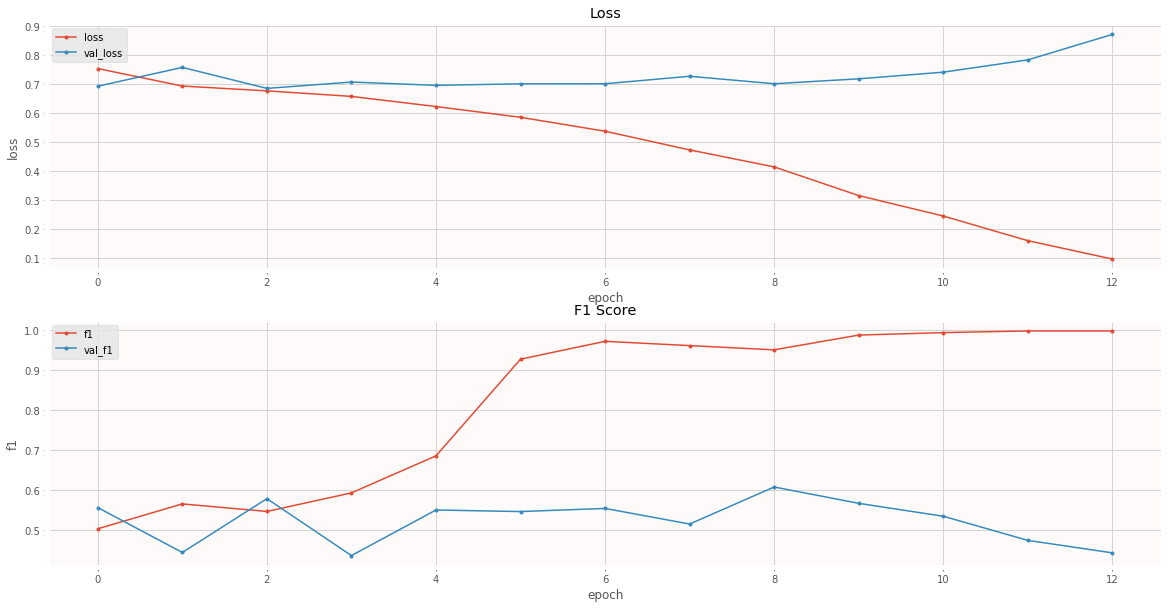

In [56]:
plot_history(history)